# Word Occurence

In this notebook we are going to look at word frequency to guide us on how many features to create. I need to do this because Google Colab's memory limit is impractical for me to generate large files. I would like to be able use files with many samples, and therefor have to find the optimal number of features to limit file size. Also, uploading the files to google colab keeps timing out for large files for me.

We will look at unigram, bigram and trigram and a combination of them to figure out how many features and which ones we should use for our dataset

Our cap for feature size is going to be 10k since the files can get quite big - ~ 8GB for 200k entries

Criteria I'm using is that whatever combination and feature size, we should have only a very small subset of examples without any features. Only 6% of our reviews are 1 star rating so target for samples without features should be much smaller than that. We will cap this at .5% to be safe

# Conclusion

As we increase the context, the likelihood of occurence of these ngrams decreases

Trigrams are interesting as it captures things like "do not buy", "does not work", "would not recommend", etc. Although this is interesting information, the percentage of occurence is really low. ~.003% occurs more than 2000 times in our corpus

Using mixture of bigram and trigram with max features of 10k seems to be the most reasonable. As we start getting features that occur

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import importlib


In [2]:
DATA_DIR = "../../dataset/amazon_reviews"

DATA_FILE = f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"

In [81]:
corpus = pd.read_csv(DATA_FILE)
corpus = corpus[["review_body", "star_rating"]].dropna()
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199134 entries, 0 to 199133
Data columns (total 2 columns):
review_body    199134 non-null object
star_rating    199134 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


# Unigrams

* there round ~50k unique words in a 200k review corpus
* with unigram - very few samples would have missing features - dorp off is aorund 3000 features - you start getting words that only occur 100+ times in the corpus
* on average a unigram occures 1500 times in our review corpus

In [8]:
missing_features1 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features1 = missing_features1.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 1657
Number of rows without features using max_features 2000: 891
Number of rows without features using max_features 3000: 607
Number of rows without features using max_features 4000: 542
Number of rows without features using max_features 5000: 410
Number of rows without features using max_features 6000: 385
Number of rows without features using max_features 7000: 371
Number of rows without features using max_features 8000: 333
Number of rows without features using max_features 9000: 318
Number of rows without features using max_features 10000: 298


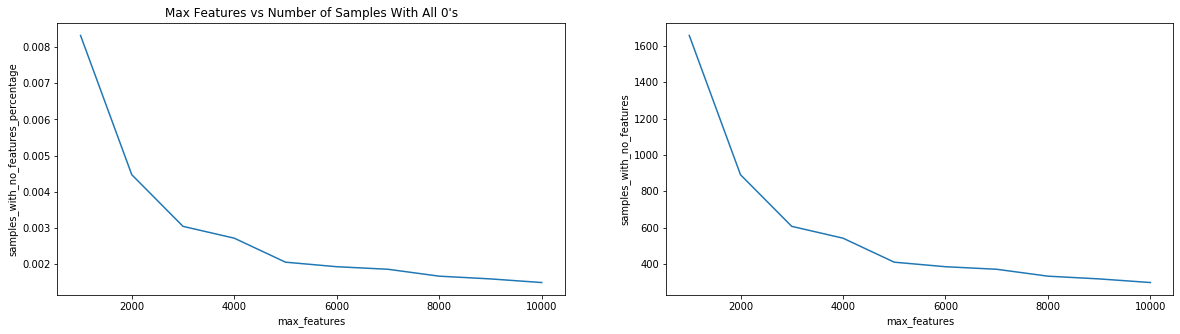

In [9]:
missing_features1["samples_with_no_features_percentage"] = missing_features1["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features1, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Max Features")
_ = sns.lineplot(data = missing_features1, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Max Features vs Number of Samples With All 0's")
_ = a[1].set_ylabel("Max Features")

In [10]:
MAX_FEATURES1 = 3000

In [11]:
cv1 = CountVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES1)
X1 = cv1.fit_transform(corpus["review_body"].array)

In [12]:
len(cv1.get_feature_names())

3000

In [13]:
np.shape(X1)

(199134, 3000)

### Word Occurences

In [15]:
count_df1 = pd.DataFrame(np.transpose(np.sum(X1, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df1.describe()

,gram_occurence
count,3000.000000
mean,1579.156667
std,5387.287574
min,120.000000
25%,207.000000
50%,418.000000
75%,1113.250000
max,154326.000000


### Top unigram occurence

              bin  gram_occurence_percent
0        (0, 100]                0.000000
1      (100, 500]               55.466667
2     (500, 1000]               17.666667
3    (1000, 2000]               11.900000
4  (2000, 154326]               14.966667


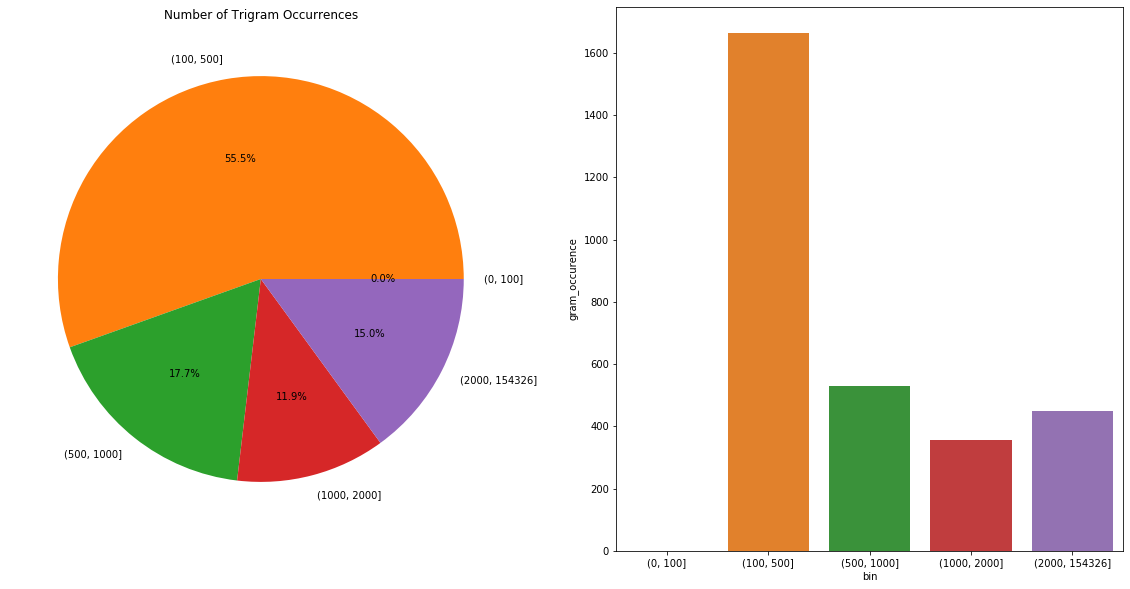

In [19]:
bins1 = count_df1.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 100, 500, 1000, 2000, x["gram_occurence"].max()]))
bins1 = pd.DataFrame(bins1.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins1["gram_occurence_percent"] = bins1["gram_occurence"] / bins1["gram_occurence"].sum() * 100

print(bins1[["bin", "gram_occurence_percent"]])

f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(bins1.gram_occurence_percent, labels=bins1.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Trigram Occurrences")

_ = sns.barplot(data = bins1, x= "bin", y="gram_occurence", ax=a[1])

10 most frequently occuring words in our features

In [23]:
top1 = count_df1.sort_values("gram_occurence", ascending=False)
np.take(cv1.get_feature_names(), top1.head(20).index.tolist())


array(['not', 'phone', 'case', 'great', 'very', 'one', 'work', 'would',
       'good', 'like', 'product', 'will', 'do', 'fit', 'screen', 'doe',
       'use', 'ti', 'well', 'get'], dtype='<U14')

10 most infrequest words in our features

In [24]:
np.take(cv1.get_feature_names(), top1.tail(20).index.tolist())


array(['nasty', 'increased', 'rare', 'fiance', 'zebra', 'quad', 'uk',
       'shoot', 'luv', 'champ', 'razor', 'assumed', 'canada', 'caveat',
       'apparent', 'bueno', 'baofeng', 'express', 'molded', 'consistent'],
      dtype='<U14')

# Bigram

* Even at around 10k features, we will have about 7% of samples without any features - using bigram alone will not meet our 1% criteria

In [26]:
missing_features2 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(2,2), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features2 = missing_features2.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 29583
Number of rows without features using max_features 2000: 23544
Number of rows without features using max_features 3000: 21013
Number of rows without features using max_features 4000: 19468
Number of rows without features using max_features 5000: 18372
Number of rows without features using max_features 6000: 17429
Number of rows without features using max_features 7000: 16775
Number of rows without features using max_features 8000: 16255
Number of rows without features using max_features 9000: 15794
Number of rows without features using max_features 10000: 15421


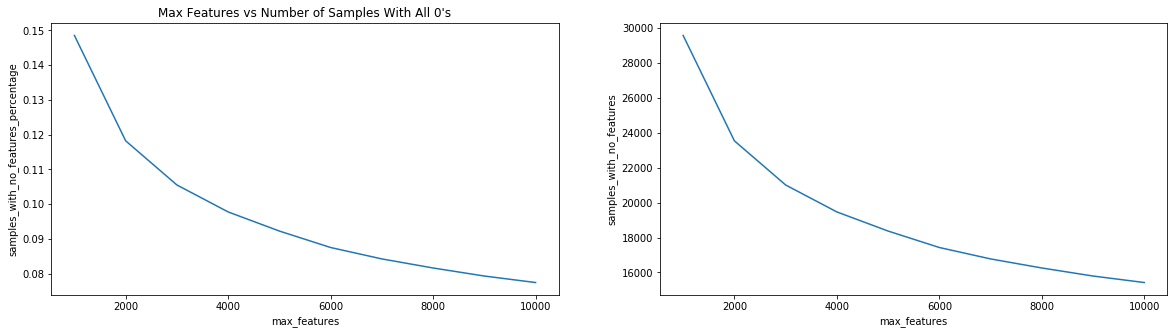

In [27]:
missing_features2["samples_with_no_features_percentage"] = missing_features2["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features2, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = sns.lineplot(data = missing_features2, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Max Features vs Number of Samples With All 0's")

In [ ]:
MAX_FEATURES2 = 5000

In [ ]:
cv2 = CountVectorizer(ngram_range=(2,2), max_features=MAX_FEATURES3)
X2 = cv2.fit_transform(corpus["review_body"].array)

In [ ]:
len(cv2.get_feature_names())

In [ ]:
np.shape(X2)

### Word Count

In [ ]:
count_df2 = pd.DataFrame(np.transpose(np.sum(X2, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df2.describe()

10 most frequently occuring bigram

In [ ]:
count_df2 = count_df2.sort_values("gram_occurence", ascending=False)
np.take(cv2.get_feature_names(), count_df2.head(20).index.tolist())

10 most infrequently occuring bigram

In [ ]:
np.take(cv3.get_feature_names(), count_df2.tail(20).index.tolist())

# Trigram

* if we use all 10k trigrams we would still have >35% samples without any features -> trigram alone as features is not a viable solution
* however, trigrams are interesting because you start getting phrases like 'do not work', 'does not fit', etc
* perhaps combining trigram with other grams would be better

In [28]:
missing_features3 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 2000):
    cv = CountVectorizer(ngram_range=(3,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features3 = missing_features3.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 109109
Number of rows without features using max_features 3000: 89008
Number of rows without features using max_features 5000: 79786
Number of rows without features using max_features 7000: 74201
Number of rows without features using max_features 9000: 69853


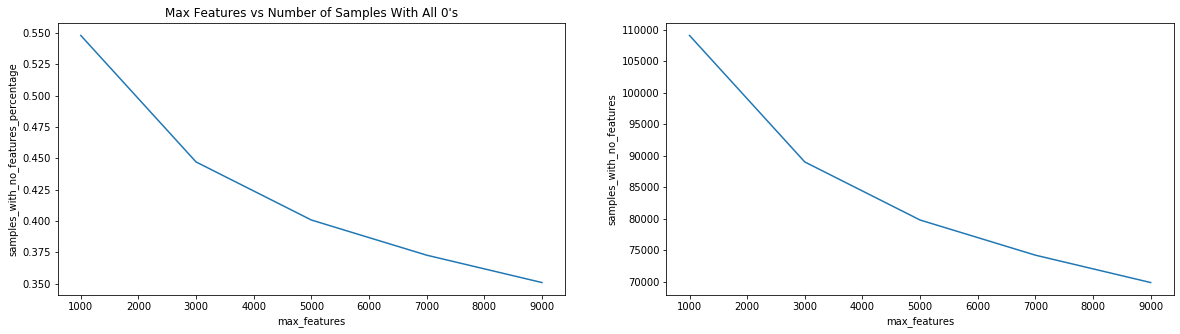

In [29]:
missing_features3["samples_with_no_features_percentage"] = missing_features3["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features3, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = sns.lineplot(data = missing_features3, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[0].set_title("Max Features vs Number of Samples With All 0's")

In [30]:
MAX_FEATURES3 = 10000

In [31]:
cv3 = CountVectorizer(ngram_range=(3,3), max_features=MAX_FEATURES3)
X3 = cv3.fit_transform(corpus["review_body"].array)

In [32]:
len(cv3.get_feature_names())

10000

In [33]:
np.shape(X3)

(199134, 10000)

### Word Count

In [34]:
count_df3 = pd.DataFrame(np.transpose(np.sum(X3, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df3.describe()

,gram_occurence
count,10000.000000
mean,44.707900
std,83.227598
min,16.000000
25%,19.000000
50%,25.000000
75%,41.000000
max,2434.000000


10 most frequently occuring trigram

In [35]:
count_df3 = count_df3.sort_values("gram_occurence", ascending=False)
np.take(cv3.get_feature_names(), count_df3.head(20).index.tolist())

array(['doe not work', 'did not work', 'doe not fit', 'do not know',
       'do not buy', 'first ti ame', 'did not fit', 'case doe not',
       'long ti ame', 'do not like', 'every ti ame',
       'would not recommend', 'work very well', 'several ti ames',
       'phone doe not', 'fit phone perfectly', 'can not beat',
       'not fit phone', 'do not want', 'do not think'], dtype='<U29')

10 most infrequently occuring trigram

In [36]:
np.take(cv3.get_feature_names(), count_df3.tail(20).index.tolist())

array(['no problem doe', 'button top phone', 'new trent case',
       'stand test ti', 'new york city', 'speck candyshell case',
       'nice case protects', 'nice feel good', 'cover belt clip',
       'sound way better', 'sound quality volume', 'couple week no',
       'sound quality no', 'buy another phone', 'buy better one',
       'sound great no', 'couple month no', 'sound even better',
       'sorry do not', 'no longer able'], dtype='<U29')

### Word Occurences

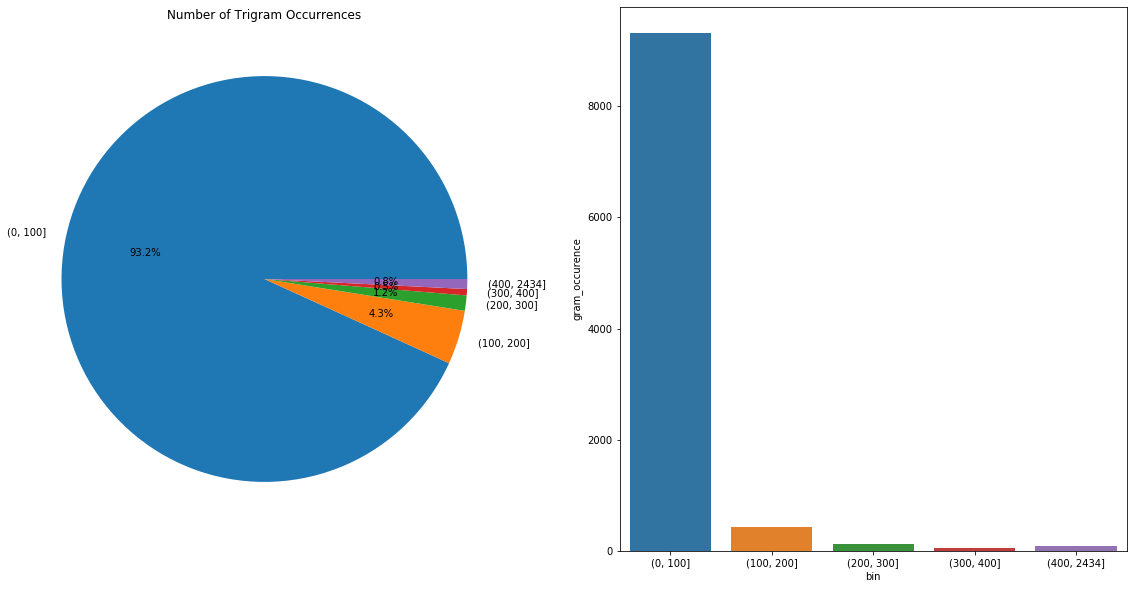

In [37]:
bins3 = count_df3.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 100, 200, 300, 400, x["gram_occurence"].max()]))
bins3 = pd.DataFrame(bins3.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins3["gram_occurence_percent"] = bins3["gram_occurence"] / bins3["gram_occurence"].sum() * 100

bins3[["bin", "gram_occurence_percent"]]

f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(bins3.gram_occurence_percent, labels=bins3.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Trigram Occurrences")

_ = sns.barplot(data = bins3, x= "bin", y="gram_occurence", ax=a[1])

### very few trigrams occur more than 50 times in the corpus

In [40]:
count_df3[count_df3 > 500].count()

gram_occurence    47
dtype: int64

# Bigram + Trigram

* With bigram + trigram - at 10k features, we would still have about 8% samples with all 0 features. Again this does not meet our criteria


In [41]:
missing_features23 = pd.DataFrame()
for max_features in np.arange(1000, 20001, 1000):
    cv = CountVectorizer(ngram_range=(2,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features23 = missing_features23.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 30599
Number of rows without features using max_features 2000: 24470
Number of rows without features using max_features 3000: 21866
Number of rows without features using max_features 4000: 20260
Number of rows without features using max_features 5000: 19152
Number of rows without features using max_features 6000: 18242
Number of rows without features using max_features 7000: 17444
Number of rows without features using max_features 8000: 16899
Number of rows without features using max_features 9000: 16430
Number of rows without features using max_features 10000: 16034
Number of rows without features using max_features 11000: 15692
Number of rows without features using max_features 12000: 15379
Number of rows without features using max_features 13000: 15052
Number of rows without features using max_features 14000: 14811
Number of rows without features using max_features 15000: 14592
Number of rows without features using max_feature

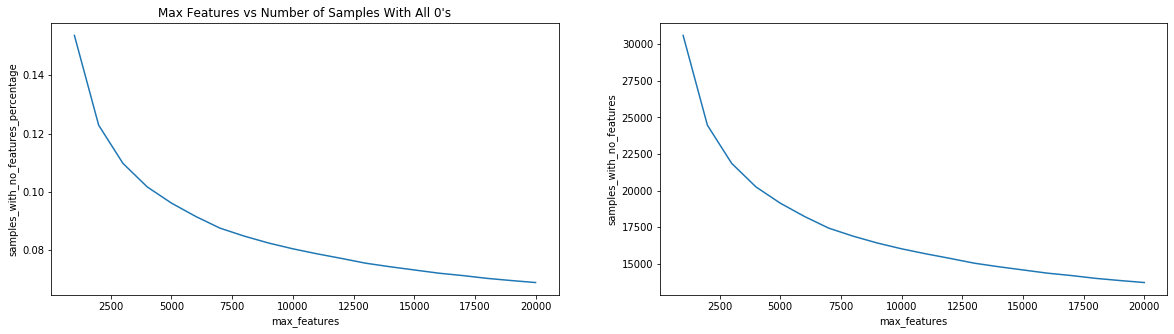

In [42]:
missing_features23["samples_with_no_features_percentage"] = missing_features23["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features23, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = sns.lineplot(data = missing_features23, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[0].set_title("Max Features vs Number of Samples With All 0's")

# Unigram + Bigram + Trigram

* with 4k features, we only have about .4% samples that does not contain any of the unigrams, bigrams, or trigrams
* There is a dropoff at around 4k max features where creating more features doesn't necessarily decrease the number of samples without features that much - at most we should be creating 4000 max features


In [43]:
missing_features = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(1,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features = missing_features.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 1757
Number of rows without features using max_features 2000: 1128
Number of rows without features using max_features 3000: 1038
Number of rows without features using max_features 4000: 799
Number of rows without features using max_features 5000: 747
Number of rows without features using max_features 6000: 738
Number of rows without features using max_features 7000: 604
Number of rows without features using max_features 8000: 587
Number of rows without features using max_features 9000: 583
Number of rows without features using max_features 10000: 579


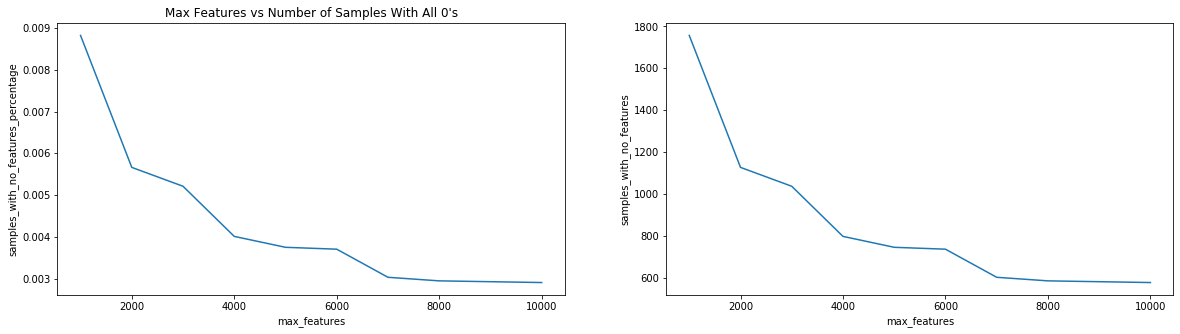

In [44]:
missing_features["samples_with_no_features_percentage"] = missing_features["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = sns.lineplot(data = missing_features, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[0].set_title("Max Features vs Number of Samples With All 0's")

In [45]:
MAX_FEATURE13=4000

In [46]:
cv13 = CountVectorizer(ngram_range=(1,3), max_features=MAX_FEATURE13)
X13 = cv13.fit_transform(corpus["review_body"].array)

In [47]:
len(cv13.get_feature_names())

4000

In [48]:
np.shape(X13)

(199134, 4000)

In [49]:
X13.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Word Occurences

In [50]:
count_df13 = pd.DataFrame(np.transpose(np.sum(X13, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df13.describe()

,gram_occurence
count,4000.000000
mean,1416.963500
std,4734.726649
min,212.000000
25%,287.000000
50%,453.000000
75%,984.500000
max,154326.000000


10 most frequently occuring words in our corpus

In [51]:
dtop_idx13 = count_df13.sort_values("gram_occurence", ascending=False)
np.take(cv13.get_feature_names(), top_idx13.head(20).index.tolist())


array(['not', 'phone', 'case', 'great', 'very', 'one', 'work', 'would',
       'good', 'like', 'product', 'will', 'do', 'fit', 'screen', 'doe',
       'use', 'ti', 'well', 'get'], dtype='<U26')

10 most infrequent unigram to trigram

In [52]:
dnp.take(cv13.get_feature_names(), top_idx13.tail(20).index.tolist())


array(['make great', 'would not stay', 'like cover', 'not receive',
       'great screen protector', 'pretty cool', 'will likely', 'handset',
       'plastic not', 'failure', 'friend family', 'another phone', 'dc',
       'high end', 'come screen protector', 'around house', 'garmin gps',
       'need get', 'also use', 'hopefully will'], dtype='<U26')

### Top unigram, bigram and trigram occurence

              bin  gram_occurence_percent
0         (0, 50]                   0.000
1        (50, 80]                   0.000
2       (80, 100]                   0.000
3      (100, 500]                  54.250
4     (500, 1000]                  21.175
5  (1000, 154326]                  24.575


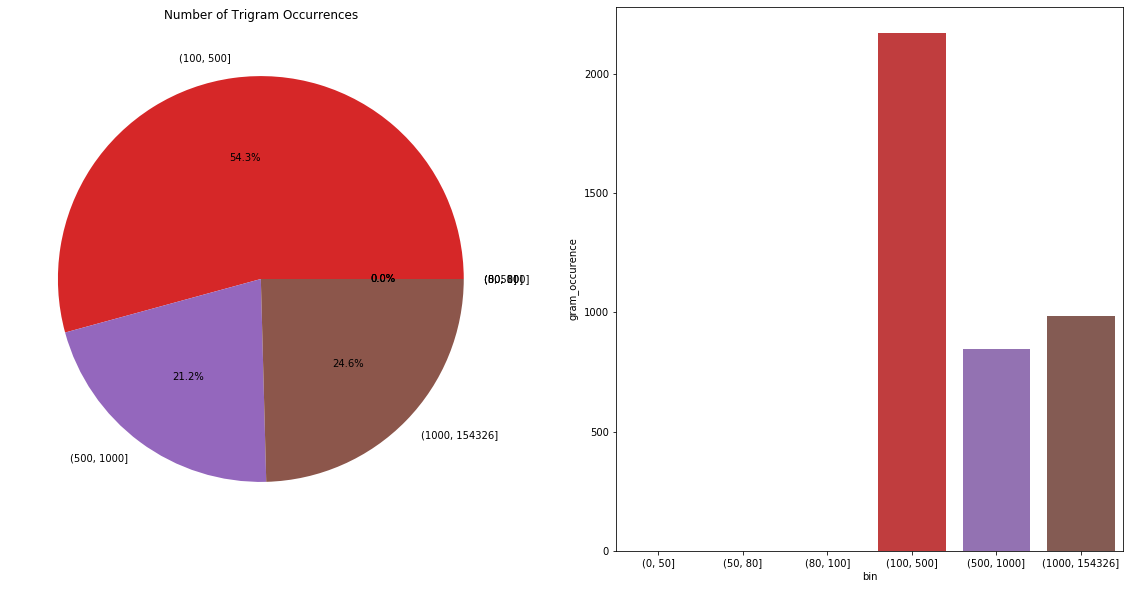

In [53]:
top_count13 = count_df13.sort_values("gram_occurence", ascending=False)
bins_13 = top_count13.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 50 , 80, 100, 500, 1000, x["gram_occurence"].max()]))
bins_13 = pd.DataFrame(bins_13.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins_13["gram_occurence_percent"] = bins_13["gram_occurence"] / bins_13["gram_occurence"].sum() * 100

print(bins_13[["bin", "gram_occurence_percent"]])

f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(bins_13.gram_occurence_percent, labels=bins_13.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Trigram Occurrences")

_ = sns.barplot(data = bins_13, x= "bin", y="gram_occurence", ax=a[1])

In [54]:
ngrams_df13 = pd.concat([pd.DataFrame(np.take(cv13.get_feature_names(), top_count13.index.tolist())),
                         top_count13["gram_occurence"].reset_index(drop=True)], axis=1).rename({0:"grams"}, axis=1)
ngrams_df13.head()

,grams,gram_occurence
0,not,154326
1,phone,110447
2,case,96886
3,great,55416
4,very,52689


### Distribution of unigram, bigram vs trigram in list

   word_count  word_count_occurence
0           1                  2224
1           2                  1549
2           3                   227
   word_count  word_count_occurence  word_count_percent
0           1                  2224              55.600
1           2                  1549              38.725
2           3                   227               5.675


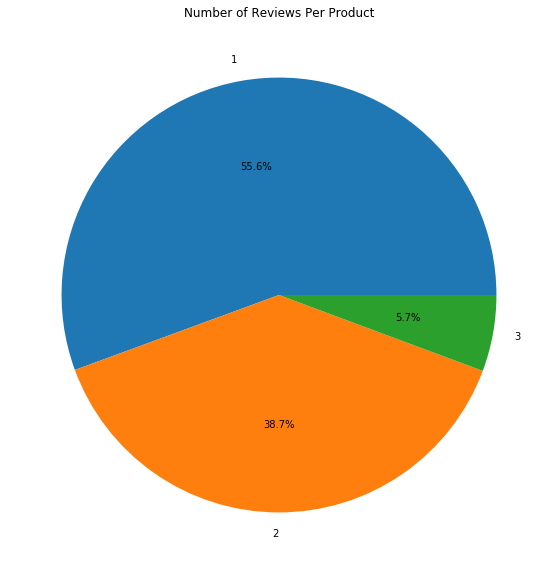

In [55]:
ngrams_df13["word_count"] = ngrams_df13.grams.str.split(" ").str.len()
top_13 = ngrams_df13[["word_count", "grams"]].groupby("word_count").count().reset_index().rename({"grams":"word_count_occurence"}, axis=1)
print(top_13)

top_13["word_count_percent"] = top_13["word_count_occurence"] / top_13["word_count_occurence"].sum() * 100
print(top_13)

f, a = plt.subplots(1, 1, figsize=(10, 10))
_ = plt.pie(top_13.word_count_percent, labels=top_13.word_count, autopct='%1.1f%%')
_ = plt.title("Number of Reviews Per Product")

### Let's Make Sure We Have Missing Features for all Star Ratings

* distribution is not exactly the same as original but there does all star ratings have missing features so that's good

In [76]:
missing_idx = np.where(~X13.toarray().any(axis=1))[0]

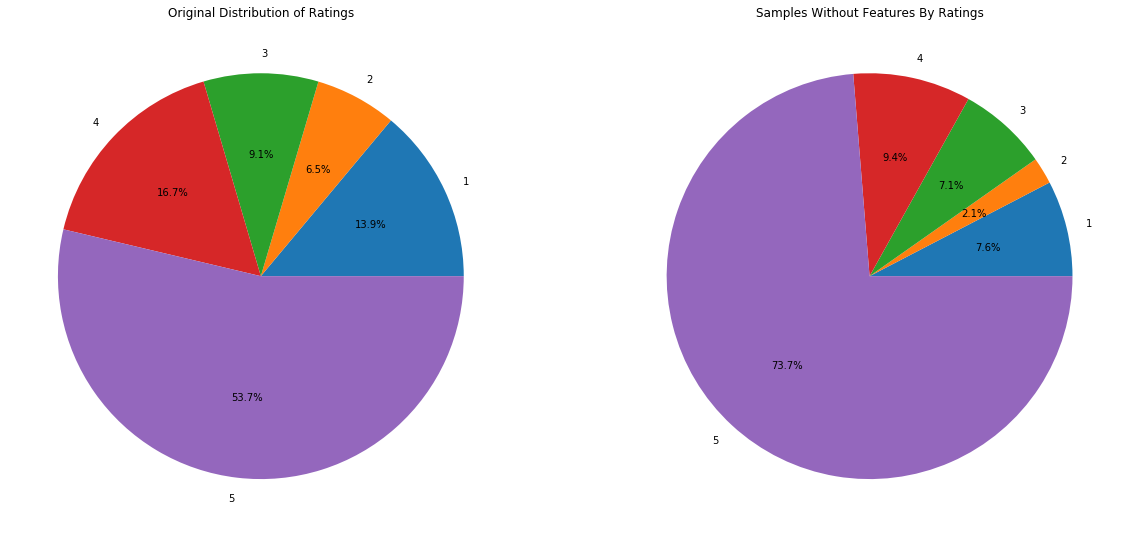

In [93]:
f, a = plt.subplots(1, 2, figsize=(20, 10))


original_dist = pd.DataFrame(corpus.groupby("star_rating").size(), columns=["count"]).reset_index()
original_dist["percent"] = original_dist["count"] / original_dist["count"].sum() * 100
_ = a[0].pie(original_dist.percent, labels=original_dist.star_rating, autopct='%1.1f%%')
_ = a[0].set_title("Original Distribution of Ratings")


missing_dist = corpus.iloc[missing_idx.tolist()][["star_rating", "review_body"]].\
                groupby("star_rating").count().rename({"review_body": "count"}, axis=1).reset_index()
missing_dist["percent"] = missing_dist["count"] / missing_dist["count"].sum() * 100
_ = a[1].pie(missing_dist.percent, labels=missing_dist.star_rating, autopct='%1.1f%%')
_ = a[1].set_title("Samples Without Features By Ratings")

